In [31]:
#!pip install praw 
#!pip install nltk 
#!pip install transformers
#!pip install torch
#!pip install perspective-api-client
#!pip install matplotlib
#!pip install seaborn
#!pip install pandas
#!pip install --upgrade jupyter ipywidgets


## Import all

In [32]:
import json
import praw
import re
import nltk
from nltk.corpus import stopwords

In [33]:
with open("config.json") as config_file:
    config = json.load(config_file)
#Here is where i load all the credencials

reddit = praw.Reddit(
    client_id=config["REDDIT_CLIENT_ID"],
    client_secret=config["REDDIT_CLIENT_SECRET"],
    user_agent=config["REDDIT_USER_AGENT"],
)

## Choose a subreddit

In [34]:
subreddit_name = "AskReddit"  # change the name by the subreddit you want
subreddit = reddit.subreddit(subreddit_name)


def get_comments(limit=100):
    comments = [comment.body for comment in subreddit.comments(limit=limit)]
    return comments


## Preprocessing the Text

In [35]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

#create a function to clean all the stopwords from my text
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)  # Eliminar URLs
    text = re.sub(r'\W', ' ', text)  # Eliminar caracteres especiales
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Eliminar stopwords
    return text

comments = get_comments(500)  # Extrae 500 comentarios
cleaned_comments = [clean_text(comment) for comment in comments]


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\guill\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Toxic-BERT


In [36]:
from transformers import pipeline

In [37]:
classifier = pipeline("text-classification", model="unitary/toxic-bert")

def analyze_toxicity(text):
    result = classifier(text)
    return result

comment = "holy mother you are uggly"
toxicity_result = analyze_toxicity(comment)
print(toxicity_result)


Device set to use cpu


[{'label': 'toxic', 'score': 0.913989245891571}]


### toxicity more complex


In [38]:
#from transformers import AutoModelForSequenceClassification, AutoTokenizer
#import torch

# Load model and tokenizer
#model_name = "unitary/toxic-bert"
#model = AutoModelForSequenceClassification.from_pretrained(model_name)
#tokenizer = AutoTokenizer.from_pretrained(model_name)

# Toxicity categories in order (from model config)
#labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

#def analyze_toxicity(text):
    # Tokenize input
#    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    
    # Run model
 #   with torch.no_grad():
  #      outputs = model(**inputs)
    
    # Convert logits to probabilities
   # probabilities = torch.sigmoid(outputs.logits).squeeze().tolist()
    
    # Format result
    #return {labels[i]: probabilities[i] for i in range(len(labels))}

# Example
#comment = "im going to kill your family, i know where you live"
#toxicity_result = analyze_toxicity(comment)

#print(toxicity_result)


## Analize toxicity


In [39]:
toxicity_results = [classifier(comment)[0] for comment in cleaned_comments]


## Save Results in a CSV

In [40]:
import pandas as pd

In [41]:
# Create DataFrame
df = pd.DataFrame({
    "comment": comments,
    "cleaned_comment": cleaned_comments,
    "toxicity_label": [res['label'] for res in toxicity_results],
    "toxicity_score": [res['score'] for res in toxicity_results]
})


#### Re-label all toxic labels

In [46]:
import pandas as pd

# Load the CSV
csv_filename = "toxic_reddit_comments.csv"
df = pd.read_csv(csv_filename)

# function to classify toxicity
def categorize_toxicity(score):
    if score >= 0.8:
        return "Highly Toxic"
    elif score >= 0.4:
        return "Moderately Toxic"
    elif score >= 0.2:
        return "Slightly Toxic"
    else:
        return "Not Toxic"

# applying the function
df["toxicity_label"] = df["toxicity_score"].apply(categorize_toxicity)

# save everything in cvs CSV
df.to_csv(csv_filename, index=False)

df.to_csv("updated_toxic_reddit_comments.csv", index=False, encoding='utf-8')



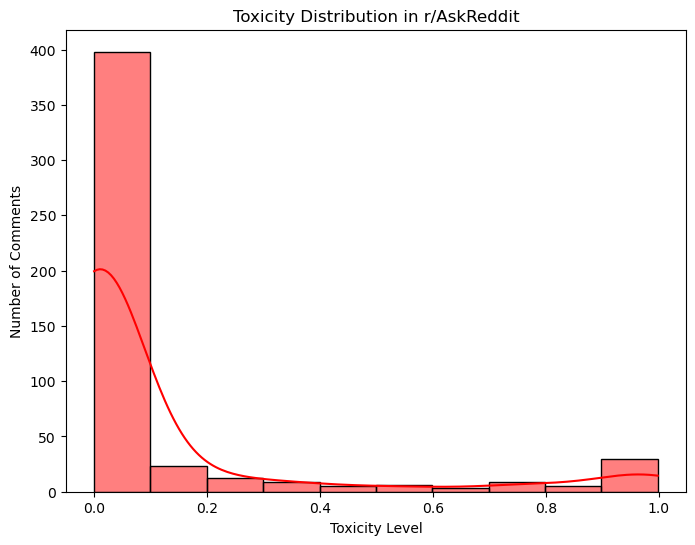

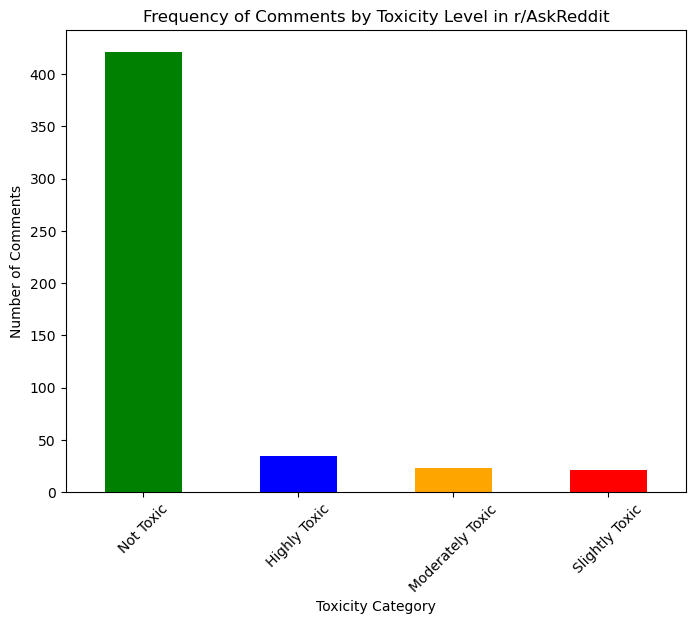

C:\Users\guill\AppData\Local\Temp\ipykernel_21100\1638900397.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="toxicity_label", y="count", data=toxic_vs_non_toxic, palette="coolwarm")


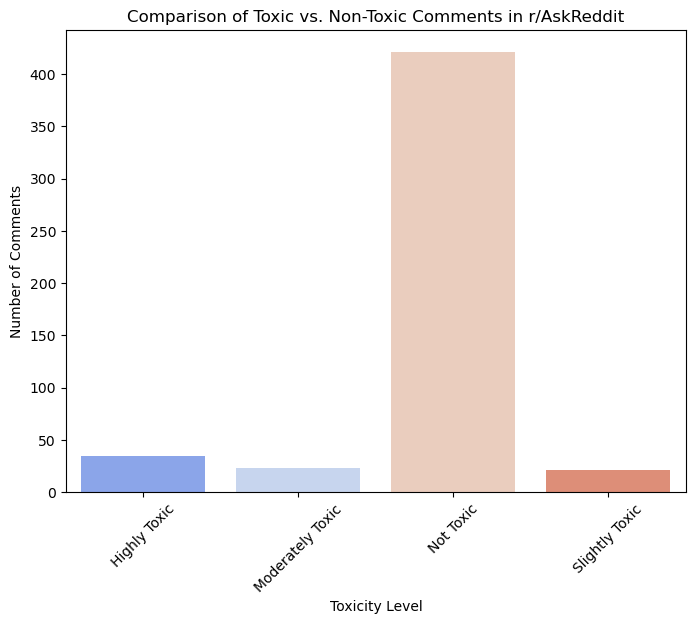

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Verify toxicity distribution
plt.figure(figsize=(8, 6))
sns.histplot(df['toxicity_score'], bins=10, kde=True, color='red')
plt.title(f"Toxicity Distribution in r/{subreddit_name}")
plt.xlabel("Toxicity Level")
plt.ylabel("Number of Comments")
plt.show()

# Count how many comments belong to each toxicity category
plt.figure(figsize=(8, 6))
df['toxicity_label'].value_counts().plot(kind='bar', color=['green', 'blue', 'orange', 'red'])
plt.title(f"Frequency of Comments by Toxicity Level in r/{subreddit_name}")
plt.xlabel("Toxicity Category")
plt.ylabel("Number of Comments")
plt.xticks(rotation=45)
plt.show()

# Compare the number of highly toxic vs. non-toxic comments
toxic_vs_non_toxic = df.groupby("toxicity_label").size().reset_index(name="count")

plt.figure(figsize=(8, 6))
sns.barplot(x="toxicity_label", y="count", data=toxic_vs_non_toxic, palette="coolwarm")
plt.title(f"Comparison of Toxic vs. Non-Toxic Comments in r/{subreddit_name}")
plt.xlabel("Toxicity Level")
plt.ylabel("Number of Comments")
plt.xticks(rotation=45)
plt.show()


In [49]:
# Calculate the average toxicity score
average_toxicity = df["toxicity_score"].mean()

# Display the result
print(f"The average toxicity score in r/{subreddit_name} is: {average_toxicity:.4f}")


The average toxicity score in r/AskReddit is: 0.1230
